# Imports

In [175]:
import sys
from pathlib import Path

AVES_ROOT = Path("../..") if not "google.colab" in sys.modules else Path("aves_git")
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd

# esto configura la calidad de la imagen. dependerá de tu resolución. el valor por omisión es 80
mpl.rcParams["figure.dpi"] = 150
# esto depende de las fuentes que tengas instaladas en el sistema.
# mpl.rcParams["font.family"] = "Fira Sans Extra Condensed"

# Carga de Datos (EOD y areas verdes)

In [176]:
# Load
areas_verdes = (
    gpd.read_file(AVES_ROOT / "data" / "project" / "Superficie_de_Areas_Verdes_Santiago.geojson")
)
print("areas_verdes: \n", areas_verdes.columns)

areas_verdes: 
 Index(['FID', 'comuna', 'estado', 'area_m2', 'area_ha', 'estado_2', 'id',
       'shapearea', 'layer', 'shape_leng', 'shape_area', 'clase',
       'Shape__Area', 'Shape__Length', 'geometry'],
      dtype='object')


In [177]:
areas_verdes["clase"].unique()

array(['PLAZA', 'BANDEJON', 'VEREDA', 'PARQUE', 'CAMPO DEPORTIVO',
       'AV PARQUE'], dtype=object)

In [178]:
from aves.data import eod
#load
EOD_PATH = AVES_ROOT / "data" / "external" / "EOD_STGO"

eod_hogares = eod.read_homes(EOD_PATH)
eod_personas = eod.read_people(EOD_PATH)
eod_viajes = eod.read_trips(EOD_PATH)

# Load
zones : gpd.GeoDataFrame = (
    gpd.read_file(AVES_ROOT / "data" / "processed" / "scl_zonas_urbanas.json")
    .set_index("ID")
    .to_crs(areas_verdes.crs)
)

# print columns
print("hogares: \n", eod_hogares.columns)
print("personas: \n", eod_personas.columns)
print("viajes: \n", eod_viajes.columns)
print("zonas: \n", zones.columns)

hogares: 
 Index(['Hogar', 'Sector', 'Zona', 'Comuna', 'DirCoordX', 'DirCoordY', 'Fecha',
       'DiaAsig', 'TipoDia', 'Temporada', 'NumPer', 'NumVeh', 'NumBicAdulto',
       'NumBicNino', 'Propiedad', 'MontoDiv', 'ImputadoDiv', 'MontoArr',
       'ImputadoArr', 'IngresoHogar', 'FactorHogar'],
      dtype='object')
personas: 
 Index(['Hogar', 'Persona', 'AnoNac', 'Sexo', 'Relacion', 'Viajes',
       'LicenciaConducir', 'PaseEscolar', 'AdultoMayor', 'Estudios', 'Curso',
       'Actividad', 'Ocupacion', 'ActividadEmpresa', 'JornadaTrabajo',
       'DondeEstudia', 'DirActividadCoordX', 'DirActividadCoordY',
       'DirEstudiosCoordX', 'DirEstudiosCoordY', 'NoViaja', 'TarjetaBip',
       'Tarjeta2Bip', 'MedioViajeRestricion', 'ConoceTransantiago',
       'NoUsaTransantiago', 'Discapacidad', 'TieneIngresos', 'Ingreso',
       'TramoIngreso', 'IngresoFinal', 'TramoIngresoFinal', 'IngresoImputado',
       'Factor_LaboralNormal', 'Factor_SabadoNormal', 'Factor_DomingoNormal',
       'Factor_La

## Arreglos a los datos

In [179]:
# fix comunas accents and uppercase
from gensim.utils import deaccent

zones["Comuna"] = zones["NOM_COMUNA"].str.upper()
zones["Comuna"] = zones["Comuna"].str.replace('Ñ', 'NN').map(deaccent).str.replace('NN', 'Ñ')

eod_viajes = eod_viajes[eod_viajes["ComunaOrigen"].notna() & eod_viajes["ComunaDestino"].notna()]
eod_viajes["ComunaOrigen"] = eod_viajes["ComunaOrigen"].str.upper()
eod_viajes["ComunaDestino"] = eod_viajes["ComunaDestino"].str.upper()

eod_viajes["ComunaOrigen"] = eod_viajes["ComunaOrigen"].str.replace('Ñ', 'NN').map(deaccent).str.replace('NN', 'Ñ')
eod_viajes["ComunaDestino"] = eod_viajes["ComunaDestino"].str.replace('Ñ', 'NN').map(deaccent).str.replace('NN', 'Ñ')

eod_hogares["Comuna"] = eod_hogares["Comuna"].str.upper()
eod_hogares["Comuna"] = eod_hogares["Comuna"].str.replace('Ñ', 'NN').map(deaccent).str.replace('NN', 'Ñ')

areas_verdes.rename(columns={"comuna": "Comuna"}, inplace=True)
areas_verdes["Comuna"] = areas_verdes["Comuna"].str.upper()
areas_verdes["Comuna"] = areas_verdes["Comuna"].str.replace('Ñ', 'NN').map(deaccent).str.replace('NN', 'Ñ')
# corregimos comunas con distinto nombre
areas_verdes["Comuna"] = areas_verdes["Comuna"].replace(["ESTACION CENTRA", "NUNOA", "PAC", "PENALOLEN"], ["ESTACION CENTRAL", "ÑUÑOA", "PEDRO AGUIRRE CERDA", "PEÑALOLEN"])
# cambiamos areas_verdes con clase "AV PARQUE" a "PARQUE"
areas_verdes["clase"] = areas_verdes["clase"].replace(["AV PARQUE"], ["PARQUE"])
# cambiamos areas_verdes con estado "DESAFECTADA e" a "DESAFECTADA"
areas_verdes["estado"] = areas_verdes["estado"].replace(["DESAFECTADA VERDE e"], ["DESAFECTADA VERDE"])

In [180]:
print("Comunas de hogares no presentes en areas_verdes: \n", set(eod_hogares["Comuna"]) - set(areas_verdes["Comuna"]))
print("Comunas de viajesDestinos no presentes en areas_verdes: \n", set(eod_viajes["ComunaDestino"]) - set(areas_verdes["Comuna"]))
print("Comunas de zones no presentes en areas_verdes: \n", set(zones["Comuna"]) - set(areas_verdes["Comuna"]))
print("Tales comunas no seran consideradas en el analisis")

# filtramos hogares por comunas presentes en areas_verdes
eod_hogares = eod_hogares[eod_hogares["Comuna"].isin(areas_verdes["Comuna"].unique())]
# filtramos viajes hacia comunas presentes en areas_verdes
eod_viajes = eod_viajes[eod_viajes["ComunaDestino"].isin(areas_verdes["Comuna"].unique())]
# filtramos zones por comunas presentes en areas_verdes
zones = zones[zones["Comuna"].isin(areas_verdes["Comuna"].unique())]

Comunas de hogares no presentes en areas_verdes: 
 {'ISLA DE MAIPO', 'EL MONTE', 'PADRE HURTADO', 'CALERA DE TANGO', 'COLINA', 'LAMPA', 'PEÑAFLOR', 'BUIN', 'MELIPILLA', 'TALAGANTE', 'PIRQUE'}
Comunas de viajesDestinos no presentes en areas_verdes: 
 {'ISLA DE MAIPO', 'EL MONTE', 'PADRE HURTADO', 'CALERA DE TANGO', 'COLINA', 'LAMPA', 'PEÑAFLOR', 'BUIN', 'MELIPILLA', 'TALAGANTE', 'PIRQUE'}
Comunas de zones no presentes en areas_verdes: 
 {'ISLA DE MAIPO', 'EL MONTE', 'PADRE HURTADO', 'CALERA DE TANGO', 'COLINA', 'LAMPA', 'PEÑAFLOR', 'BUIN', 'TALAGANTE', 'PIRQUE'}
Tales comunas no seran consideradas en el analisis


# Visualizaciones

In [219]:
viajes_persona = eod_viajes.merge(eod_personas)

viajes_persona["PesoLaboral"] = (
    viajes_persona["FactorLaboralNormal"] * viajes_persona["Factor_LaboralNormal"]
)

viajes_persona = viajes_persona[pd.notnull(viajes_persona["PesoLaboral"])]

expanded_destinos_zonas = viajes_persona.groupby(['ZonaDestino'])['PesoLaboral'].sum().rename('atraccion').to_frame()
expanded_destinos_zonas = zones.join(expanded_destinos_zonas, how='left', on='ID').fillna(0)

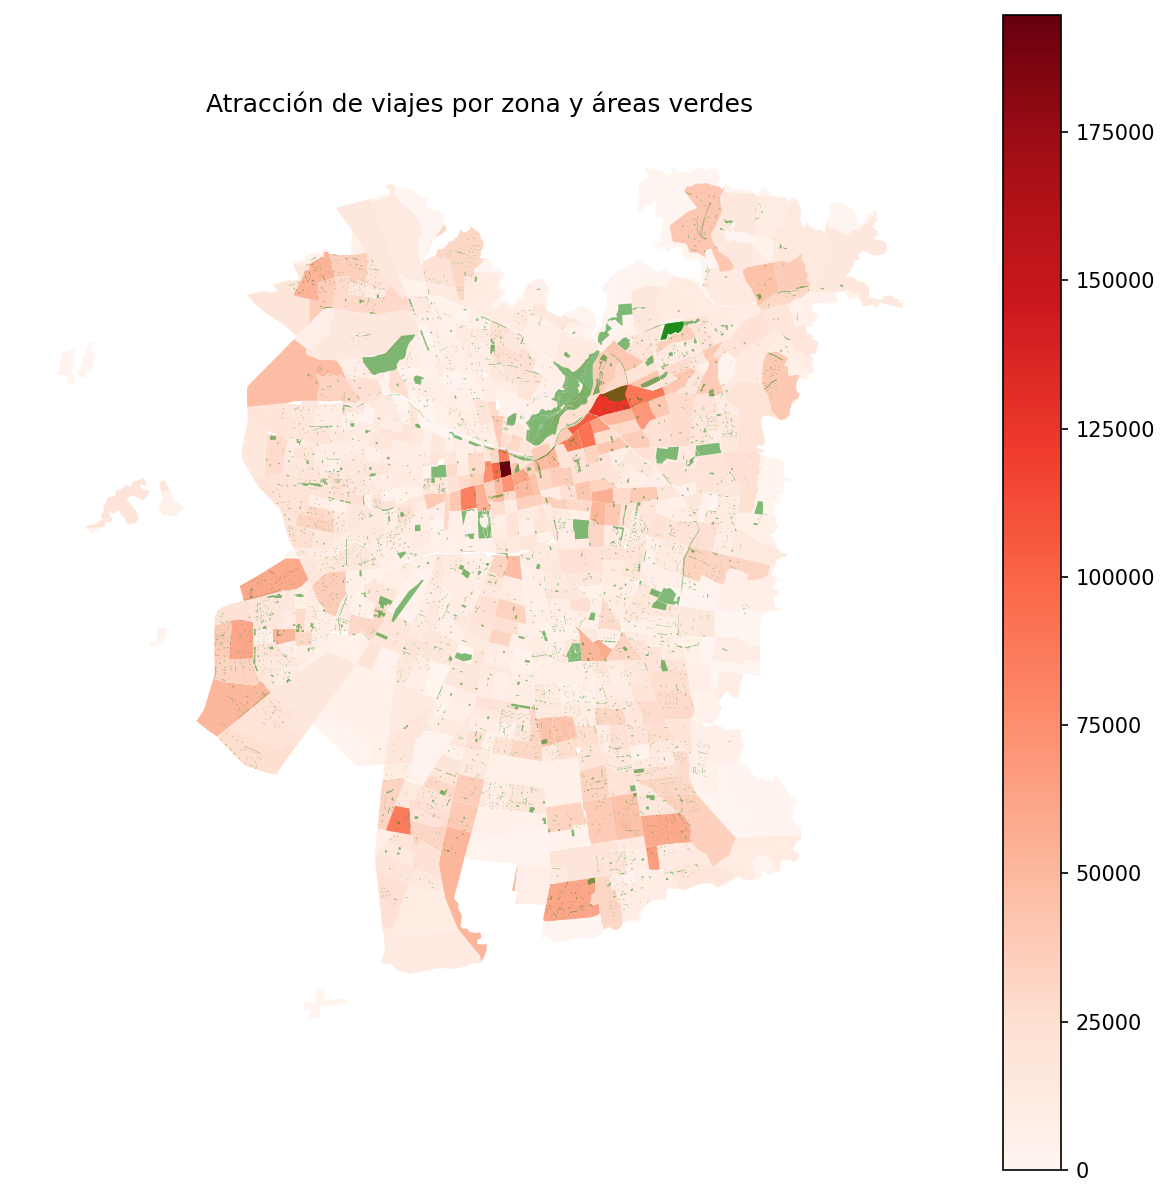

In [220]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
expanded_destinos_zonas.plot(column="atraccion", legend=True, ax=ax, cmap="Reds")
areas_verdes[areas_verdes["clase"].isin(["PLAZA", "PARQUE", "CAMPO DEPORTIVO"])].plot(
    color="green", ax=ax, alpha=0.5
)
ax.set_title("Atracción de viajes por zona y áreas verdes")
ax.set_axis_off()

In [221]:
expanded_hogares_zonas = eod_hogares.groupby("Zona")["FactorHogar"].sum().to_frame()
expanded_hogares_zonas = zones.join(expanded_hogares_zonas, how="left", on="ID").fillna(0).drop_duplicates()

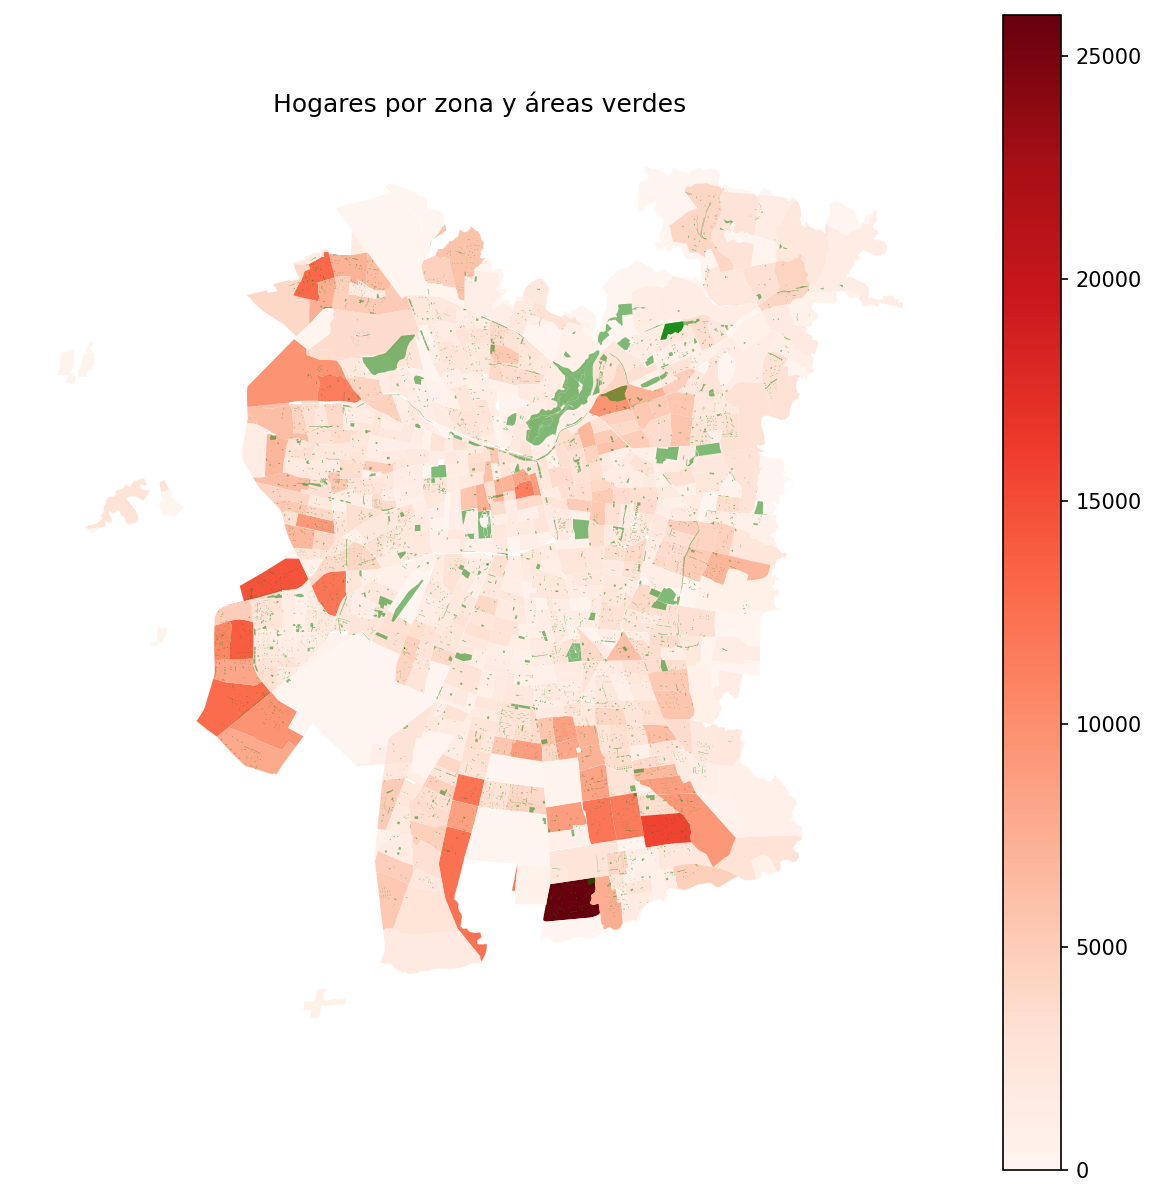

In [222]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
expanded_hogares_zonas.plot(column="FactorHogar", legend=True, ax=ax, cmap="Reds")
areas_verdes[areas_verdes["clase"].isin(["PLAZA", "PARQUE", "CAMPO DEPORTIVO"])].plot(
    color="green", ax=ax, alpha=0.5
)
ax.set_title("Hogares por zona y áreas verdes")
ax.set_axis_off()

## Datos graficados por clase

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
zones.plot(ax=ax, color="white", edgecolor="black", linewidth=0.1)
areas_verdes.plot(ax=ax, column="clase", legend=True, edgecolor="black", linewidth=0.1)
ax.set_title("Mapa de áreas verdes por clase")
ax.set_facecolor("lightgray")

In [ ]:
_comuna = "SANTIAGO"
_areas_verdes_comuna = areas_verdes[areas_verdes['Comuna'] == _comuna]
_zones_comuna = zones[zones['Comuna'] == _comuna]
fig, ax = plt.subplots(figsize=(10, 10))
_zones_comuna.plot(ax=ax, color="white", edgecolor="black", linewidth=0.1)
_areas_verdes_comuna.plot(ax=ax, column="clase", legend=True, edgecolor="black", linewidth=0.1)
ax.set_title("Mapa de áreas verdes en la comuna de Santiago por clase")
ax.set_facecolor("lightgray")

### ¿Cual es la superficie total de los tipos de areas verdes?

In [ ]:
# superficie total por tipo de área verde
superficie_total_tipo = areas_verdes.groupby("clase").agg({"area_m2": "sum", "area_ha": "sum"}).sort_values("clase", ascending=False)
superficie_total_tipo["area_km2"] = superficie_total_tipo["area_m2"] / 1e6

# plot
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(
    data=superficie_total_tipo,
    x=superficie_total_tipo.index,
    y="area_ha",
    ax=ax,
    palette="colorblind",
    dodge=False,
)
ax.set_xlabel("Tipo de área verde")
ax.set_ylabel("Área (ha)")
ax.set_title("Superficie total de áreas verdes por tipo")
sns.despine()

superficie_total_tipo


### ¿Y su promedio de superficie?

In [ ]:
# promedio de superficie por tipo
superficie_promedio_tipo = areas_verdes.groupby("clase").agg({"area_m2": "mean", "area_ha": "mean"}).sort_values("clase", ascending=False)
superficie_promedio_tipo["area_km2"] = superficie_promedio_tipo["area_m2"] / 1e6

# plot
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(
    data=superficie_promedio_tipo,
    x=superficie_promedio_tipo.index,
    y="area_ha",
    ax=ax,
    palette="colorblind",
    dodge=False,
)
ax.set_xlabel("Tipo de área verde")
ax.set_ylabel("Área (ha)")
ax.set_title("Superficie promedio de áreas verdes por tipo")
sns.despine()

superficie_promedio_tipo

## Superficie y cantidad de areas verdes por comuna

In [ ]:
area_comuna_clase = areas_verdes.groupby(["Comuna", "clase"]).agg({"area_m2": "sum", "Comuna": "count"}).rename(columns={"Comuna": "n_areas"}).reset_index()
area_comuna_clase["area_ha"] = area_comuna_clase["area_m2"] / 10000

# plot
fig, ax = plt.subplots(figsize=(16, 9))
sns.barplot(
    data=area_comuna_clase,
    x="area_ha",
    y="Comuna",
    hue="clase",
    ax=ax,
    palette="colorblind",
    dodge=False,
)
ax.set_xlabel("Área (ha)")
ax.set_ylabel("Comuna")
ax.set_title("Superficie total de áreas verdes por comuna y clase")
ax.legend(title="Clase", loc="upper right")
sns.despine()

area_comuna_clase

In [ ]:
cantidad_comuna_estado = areas_verdes.groupby(["Comuna", "estado"]).agg({"area_m2": "sum", "Comuna": "count"}).rename(columns={"Comuna": "n_areas"}).reset_index()
cantidad_comuna_estado["area_ha"] = cantidad_comuna_estado["area_m2"] / 10000

# plot
fig, ax = plt.subplots(figsize=(16, 9))
sns.barplot(
    data=cantidad_comuna_estado,
    x="area_ha",
    y="Comuna",
    hue="estado",
    ax=ax,
    palette="colorblind",
    dodge=False,
)
ax.set_xlabel("Área (ha)")
ax.set_ylabel("Comuna")
ax.set_title("Superficie total de áreas verdes por comuna y estado")
ax.legend(title="Estado", loc="upper right")
sns.despine()

cantidad_comuna_estado

### ¿Cantidad de Areas verdes se relaciona con la poblacion?
agregar grafico con areas verdes por cada 1000 habitantes

In [ ]:
# obtenemos la población de cada comuna
persona_hogar = eod_personas.merge(eod_hogares)
poblacion_por_comuna = persona_hogar.groupby('Comuna')['FactorPersona'].sum().rename('population')

# obtenemos areas verdes por comuna y clase
area_comuna_clase = areas_verdes.groupby(["Comuna", "clase"]).agg({"area_m2": "sum", "Comuna": "count", "area_ha": "sum"}).rename(columns={"Comuna": "n_areas"}).reset_index()

# obtenemos hectareas de areas verdes por 1000 habitantes
area_comuna_clase_por_1000_habitantes = area_comuna_clase.merge(poblacion_por_comuna, on='Comuna')
area_comuna_clase_por_1000_habitantes['area_ha_por_1000_habitantes'] = area_comuna_clase_por_1000_habitantes['area_ha'] / area_comuna_clase_por_1000_habitantes['population'] * 1000

# plot
fig, ax = plt.subplots(figsize=(16, 9))
sns.barplot(
    data=area_comuna_clase_por_1000_habitantes,
    x="area_ha_por_1000_habitantes",
    y="Comuna",
    hue="clase",
    ax=ax,
    palette="colorblind",
    dodge=False,
)
ax.set_xlabel("Área (ha) x 1000 habitantes")
ax.set_ylabel("Comuna")
ax.set_title("Superficie total de áreas verdes por comuna y clase por cada 1000 habitantes")
ax.legend(title="Clase", loc="upper right")
sns.despine()

area_comuna_clase_por_1000_habitantes

### ¿Cuanta gente vive cerca de cada area verde?


In [ ]:
# consideramos solo parques, plazas y campos deportivos para este análisis

# obtenemos parques, plazas y campos deportivos
areas_verdes_ppcd = areas_verdes[areas_verdes['clase'].isin(['PARQUE', 'PLAZA', 'CAMPO DEPORTIVO'])]

# definimos cuanto es "cerca" (en metros)
cerca = 500

# obtenemos la cantidad de hogares cerca de cada area verde



### ¿Cuanta gente trabaja cerca de cada area verde?

In [ ]:
viajes_por_trabajo = eod_viajes[eod_viajes['Proposito'] == 'Al trabajo'].groupby('ZonaDestino')['FactorLaboralNormal'].sum().rename('viajes_por_trabajo').sort_values(ascending=False).reset_index()
viajes_por_trabajo


### ¿Flujo de personas cerca de cada areas verde?


### ¿Hay correlacion entre tasa de areas verdes por habitante e ingreso comunal promedio?

In [ ]:
from aves.features.utils import weighted_mean
from aves.visualization.tables import scatterplot

# obtenemos ingreso promedio por comuna
ingreso_comunal_promedio = eod_hogares.groupby('Comuna').apply(lambda x: weighted_mean(x, 'IngresoHogar', 'FactorHogar')).rename('ingreso promedio')
ingreso_comunal_promedio

# obtenemos la población de cada comuna
persona_hogar = eod_personas.merge(eod_hogares)
poblacion_por_comuna = persona_hogar.groupby('Comuna')['FactorPersona'].sum().rename('population')

# obtenemos areas verdes por comuna
area_comuna = areas_verdes.groupby("Comuna").agg({"area_m2": "sum", "Comuna": "count", "area_ha": "sum"}).rename(columns={"Comuna": "n_areas"}).reset_index()

# obtenemos hectareas de areas verdes por 1000 habitantes
area_comuna_por_1000_habitantes = area_comuna.merge(poblacion_por_comuna, on='Comuna')
area_comuna_por_1000_habitantes['area_ha_por_1000_habitantes'] = area_comuna_por_1000_habitantes['area_ha'] / area_comuna_por_1000_habitantes['population'] * 1000

df = area_comuna_por_1000_habitantes.merge(ingreso_comunal_promedio, on='Comuna')[['Comuna', 'area_ha_por_1000_habitantes', 'ingreso promedio']]
df.index = df['Comuna']
df = df.drop('Comuna', axis=1)

#plot
fig, ax = plt.subplots(figsize=(16, 9))
scatterplot(
    ax=ax,
    df=df,
    x="ingreso promedio",
    y="area_ha_por_1000_habitantes",
    annotate=True,
    avoid_collisions=True,
    text_args=dict(fontsize="small"),
    scatter_args=dict(color="purple"),
)
ax.set_xlabel("Ingreso promedio")
ax.set_ylabel("Área (ha) x 1000 habitantes")
ax.set_title("Relación entre superficie de áreas verdes por cada 1000 habitantes e ingreso promedio por comuna")
ax.grid(alpha=0.5)
ax.ticklabel_format(style="plain")

sns.despine(ax=ax, left=True, bottom=True, right=True, top=True)

#df.sort_values('ingreso promedio', ascending=False)
df.sort_values('area_ha_por_1000_habitantes', ascending=False)

### ¿Cual es la distribucion de distancia o tiempo de viaje a areas verdes en distintos sectores de la ciudad?

### ¿Cual es el porcentaje de area verde con respecto al area total de la comuna?